## Comparación de regresores para evaluación crediticia

Importamos las bibliotecas necesarias para la estructura de los datos y operaciones matemáticas:

In [1]:
import pandas
import numpy
import cmath
import random
import pydotplus
import warnings

Importamos los módulos de los regresores que vamos a comparar:

1. [`SymbolicRegressor`](http://gplearn.readthedocs.io/en/stable/reference.html#symbolic-regressor): Regresor simbólico*
2. [`RandomForestRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html): Regresor de ensamblaje Random Forest
3. [`DecisionTreeRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html): Regresor de árboles de decisión
4. [`MLPRegressor`](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html): Regresor de red neuronal artificial multicapa

*Un regresor simbólico es un estimador que crea una población de fórmulas aleatorias para intentar representar una relación. Las fórmulas se representan en estructuras de árbol con funciones matemáticas que recursivamente se aplican a las variables y constantes. Cada generación de programas sucesiva es luego evolucionada de la que vino antes, seleccionando a los individuos más aptos de la población para soportar operaciones genéticas como cruzamiento, mutación y reproducción.

In [2]:
from gplearn.genetic import SymbolicRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor

Importamos el módulo que usaremos para validación cruzada y para la visualización de la regresión simbólica:

In [3]:
warnings.filterwarnings('ignore')
from sklearn.cross_validation import ShuffleSplit
from IPython.display import Image

Almacenamos la data de evaluación crediticia en un data frame:

In [4]:
data = pandas.read_csv('credit.csv')

Definimos las columnas para las características y para el objetivo:

In [5]:
features = data.drop(['CLASSE'], axis=1).columns.tolist()
target = ['CLASSE']

print "Características: {}".format(features)
print "Objetivo: {}".format(target)

Características: ['ESTC', 'NDEP', 'RENDA', 'TIPOR', 'VBEM', 'NPARC', 'VPARC', 'TEL', 'IDADE', 'RESMS', 'ENTRADA']
Objetivo: ['CLASSE']


Separamos la data las características y objetivo previamente definidos:

In [6]:
X_all = data[features]
y_all = data[target]

Separamos la data en datos de entrenamiento y testeo:

In [7]:
X = numpy.array(X_all)
y = numpy.array(y_all)

for i, j in ShuffleSplit(len(X), n_iter=100, test_size=.3):
    X_train, X_test = X[i], X[j]
    y_train, y_test = y[i], y[j]

print "El conjunto de entrenamiento tiene {} observaciones.".format(X_train.shape[0])
print "El conjunto de testeo tien {} observaciones.".format(X_test.shape[0])

X_train, X_test = pandas.DataFrame(X_train), pandas.DataFrame(X_test)
y_train, y_test = pandas.DataFrame(y_train), pandas.DataFrame(y_test)

El conjunto de entrenamiento tiene 4361 observaciones.
El conjunto de testeo tien 1870 observaciones.


Inicializamos los distintos regresores con sus respectivos parámetros:

In [8]:
SRE = SymbolicRegressor(generations=10, stopping_criteria=0.00,
           p_crossover=0.4, p_subtree_mutation=0.4,
           p_hoist_mutation=0.05, p_point_mutation=0.1,
           max_samples=0.9, trigonometric=True, transformer=True,
           parsimony_coefficient=0.01, random_state=0)

DTR = DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False,
           splitter='best')

RFR = RandomForestRegressor(criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=20,
           min_samples_leaf=1,oob_score=True)

MLP = MLPRegressor(activation='logistic', alpha=0.0001, epsilon=1e-08,
           learning_rate_init=0.001, max_iter=200, momentum=0.9,
           solver='sgd')

Evaluamos el fitness de cada regresor y hallamos el error cuadrático promedio con relación a la data de testeo:

In [9]:
regressor_names, i = ['SRE ', 'DTR ', 'RFR ', 'MLP '], 0
for regressor in [SRE, DTR, RFR, MLP]:
    regressor.fit(X_train, y_train.values.ravel())
    print regressor_names[i] + str(regressor.score(X_test, y_test))
    i += 1

SRE 0.110423678849
DTR 0.680529327102
RFR 0.710664732532
MLP 0.119802535255


Visualizamos el programa hallado por la regresión simbólica a través de un árbol:

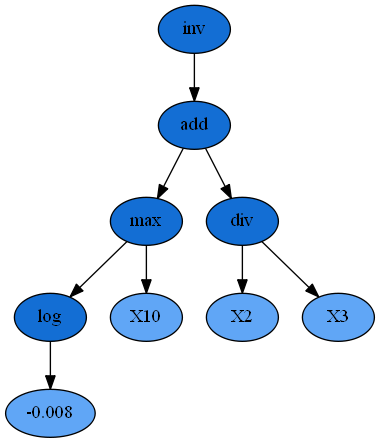

In [10]:
graph = pydotplus.graphviz.graph_from_dot_data(SRE._program.export_graphviz())
Image(graph.create_png())

Lo que nos dice el árbol resultante del regresor simbólico es que la relación entre las variables $X_{2}$ (número de dependientes), $X_{3}$ (renta familiar), $X_{10}$ (tiempo de residencia) e $y$ (tiene capacidad de pago o no) se puede explicar a través de la siguiente ecuación:

$y \approx \max(\log_{10}(-0.008), X_{10}) + \frac{X_{2}}{X_{3}})^{-1}$

Si tomamos 100 ejemplos aleatorios de la base de datos, podemos probar si la regresión simbólica es efectiva para los casos en los que la clase es 1, hallando el ratio de verdaderos positivos a falsos positivos:

In [14]:
actual_accumulator = 0
total_accumulator = 0

for i in range(100):
    random_tuple = data.iloc[random.randint(0,len(data)-1)]
    predicted = (max(cmath.log(-0.008),random_tuple['RESMS']) + random_tuple['NDEP']/random_tuple['RENDA'])**(-1)
    actual = random_tuple['CLASSE']
    if (predicted >= 1):
        if (actual == 1):
            actual_accumulator += 1
        print str(actual) + ' vs ' + str(1)
        total_accumulator += 1
        
print actual_accumulator / float(total_accumulator)

1 vs 1
0 vs 1
1 vs 1
1 vs 1
1 vs 1
1 vs 1
1 vs 1
0 vs 1
1 vs 1
1 vs 1
0 vs 1
1 vs 1
0 vs 1
1 vs 1
1 vs 1
1 vs 1
0 vs 1
1 vs 1
1 vs 1
1 vs 1
1 vs 1
1 vs 1
1 vs 1
0 vs 1
1 vs 1
0.76
